In [17]:
def all_files(list_file):
    file_names = []
    with open(list_file, 'rb') as f:
        for line in f:
            file_names.append(line.split()[0])
    return file_names

In [18]:
from heapq import nlargest
from collections import Counter

In [19]:
train_files = all_files('/Users/ecsark/Documents/visualdb/project/wikiart/train.txt')
test_files = all_files('/Users/ecsark/Documents/visualdb/project/wikiart/test.txt')

In [22]:
def all_artist_years(file_names):
    artists = list()
    years = list()
    for f in file_names:
        a = f.split('.')[0].split('/')[-1].split('_')
        artists.append(a[0])
        b = a[-1].split('-')
        year = None
        if len(b) > 1 and b[-1].isdigit():
            for n in reversed(b):
                if n.isdigit():
                    if len(n)==4:
                        year = int(n)
                        break
                else:
                    break
        
        years.append(year)
            
    return artists, years

In [23]:
test_artists, test_years = all_artist_years(test_files)
train_artists, train_years = all_artist_years(train_files)

In [24]:
print len(train_artists),  sum([1 if year is not None else 0 for year in train_years])
print len(test_artists),  sum([1 if year is not None else 0 for year in test_years])

8000 4435
2000 1095


In [25]:
print len(set(train_artists))
print len(set(test_artists))

684
460


In [26]:
import caffe
import lmdb
import os
import caffe.proto.caffe_pb2
from caffe.io import datum_to_array
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import distance

In [27]:
def read_from_db(db_dir):
    lmdb_env = lmdb.open(db_dir)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    datum = caffe.proto.caffe_pb2.Datum()

    D = []

    for idx, (key, value) in enumerate(lmdb_cursor):
        datum.ParseFromString(value)
        data = caffe.io.datum_to_array(datum)
        D.append(data.flatten())

    lmdb_env.close()
    return D

In [28]:
X_train = read_from_db('/Users/ecsark/Documents/visualdb/project/wikiart/train_vgg_feature_fc7')

In [11]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, train_artists)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
trained_artists = set(train_artists)
X_q_test = list()
y_q_test = list()
for y, X in zip(test_artists, X_test):
    if y in trained_artists:
        X_q_test.append(X)
        y_q_test.append(y)
        
y_pred = clf.predict(X_q_test)
error = sum([1 if p!=g else 0 for (p, g) in zip(y_pred, y_q_test)])
print 1.0 - 1.0*error/len(y_q_test)

0.255943348508


In [1]:
import cPickle as pk
clf = pk.load(open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/model/vgg_artists.pk', 'rb'))

In [2]:
import math
def convert_to_votes(decision):
    return (np.array(decision)>0).sum(axis=1).tolist()

class PretrainedSVC:
    def __init__(self, model):
        self.svc = model

    def predict(self, image_features):
        return self.svc.predict(image_features)

    def get_decision(self, fts):
        decisions = self.svc.decision_function(fts)
        n_classes = int((1+math.sqrt(1+8*len(decisions[0]))) / 2)
        scores = []
        idx = 0
        for i in range(n_classes):
            i_score = []
            for j in range(i):
                i_score.append(-scores[j][i])
            i_score.append(0)
            for k in range(n_classes - i - 1):
                i_score.append(decisions[0][idx])
                idx += 1
            scores.append(i_score)
        return scores

In [3]:
svc = PretrainedSVC(clf)

In [86]:
def firstKClosure(firstK_list):
    firstK_list = sorted(firstK_list)
    hits = [0] * len(firstK_list)
    for x, y in zip(X_q_test, y_q_test):
        votes = convert_to_votes(svc.get_decision(x.reshape(1, -1)))
        all_possible_artists = [clf.classes_[i] for i in np.argsort(votes)[::-1][:firstK_list[-1]]]
        for i, firstK in enumerate(firstK_list):
            if y in all_possible_artists[:firstK]:
                hits[i] += 1
    return hits

In [87]:
firstKClosure([1,2,4,8,16])

[505, 635, 793, 942, 1090]

In [88]:
len(X_q_test)

1977

In [8]:
scores_train = list()
for x in X_train:
    scores_train.append(convert_to_votes(svc.get_decision(x.reshape(1,-1))))

/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:547: ChangedBehaviorWarning: The decision_function_shape default value will change from 'ovo' to 'ovr' in 0.18. This will change the shape of the decision function returned by SVC.
  "SVC.", ChangedBehaviorWarning)


In [41]:
import cPickle as pickle
scores_train = pickle.load(open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/model/artist_decision_votes_train.pk', 'rb'))

In [42]:
scores_train[0]

[337,
 286,
 464,
 41,
 342,
 36,
 338,
 420,
 424,
 400,
 456,
 245,
 501,
 479,
 379,
 508,
 121,
 548,
 89,
 469,
 83,
 18,
 324,
 515,
 58,
 295,
 417,
 130,
 195,
 258,
 561,
 212,
 422,
 351,
 490,
 444,
 261,
 435,
 547,
 425,
 554,
 273,
 549,
 561,
 24,
 555,
 404,
 496,
 396,
 591,
 590,
 628,
 253,
 69,
 23,
 241,
 340,
 245,
 475,
 151,
 620,
 384,
 177,
 414,
 350,
 121,
 563,
 182,
 592,
 576,
 112,
 429,
 407,
 11,
 501,
 600,
 261,
 196,
 599,
 513,
 265,
 589,
 250,
 475,
 678,
 452,
 15,
 315,
 19,
 619,
 550,
 378,
 444,
 512,
 617,
 425,
 210,
 31,
 529,
 556,
 255,
 102,
 190,
 234,
 273,
 208,
 88,
 590,
 21,
 291,
 437,
 149,
 644,
 173,
 56,
 523,
 344,
 278,
 5,
 138,
 105,
 38,
 3,
 142,
 476,
 293,
 37,
 304,
 51,
 411,
 97,
 593,
 208,
 578,
 485,
 285,
 546,
 508,
 319,
 382,
 14,
 526,
 110,
 562,
 33,
 217,
 74,
 92,
 660,
 160,
 660,
 40,
 562,
 437,
 561,
 360,
 172,
 90,
 628,
 612,
 129,
 332,
 229,
 13,
 641,
 477,
 312,
 482,
 341,
 257,
 250,
 446,

In [15]:
c = Counter()
for a in test_artists:
    if a in trained_artists:
        c[a] += 1

In [18]:
import operator
sorted_x = sorted(c.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

[('giovanni-battista-piranesi', 91),
 ('nicholas-roerich', 70),
 ('vincent-van-gogh', 47),
 ('salvador-dali', 40),
 ('pablo-picasso', 34),
 ('gustave-dore', 28),
 ('rembrandt', 27),
 ('peter-paul-rubens', 26),
 ('raphael-kirchner', 25),
 ('claude-monet', 24),
 ('pierre-auguste-renoir', 18),
 ('odilon-redon', 18),
 ('paul-cezanne', 17),
 ('boris-kustodiev', 16),
 ('john-singer-sargent', 15),
 ('jean-auguste-dominique-ingres', 15),
 ('martiros-saryan', 15),
 ('max-ernst', 15),
 ('amedeo-modigliani', 14),
 ('ernst-ludwig-kirchner', 14),
 ('zdislav-beksinski', 14),
 ('egon-schiele', 13),
 ('ilya-repin', 13),
 ('jacek-yerka', 13),
 ('zinaida-serebriakova', 13),
 ('pyotr-konchalovsky', 13),
 ('rene-magritte', 13),
 ('henri-matisse', 13),
 ('james-tissot', 13),
 ('henri-de-toulouse-lautrec', 12),
 ('marc-chagall', 12),
 ('william-adolphe-bouguereau', 12),
 ('maurice-prendergast', 11),
 ('john-william-godward', 11),
 ('edouard-cortes', 11),
 ('camille-corot', 11),
 ('ivan-aivazovsky', 11),
 ('

In [19]:
print len(y_q_test)

1977


In [35]:
def all_samples_year(X_train, all_years):
    X_year = list()
    for year, x in zip(all_years, X_train):
        if year is not None:
            X_year.append(year)
        else:
            X_year.append(reg.predict([x])[0])
            
    return X_year

In [36]:
all_year_samples = all_samples_year(X_train, train_years)

In [40]:
import cPickle as pk
pk.dump([[i] for i in all_year_samples], 
        open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/model/year_decision_scores_train.pk', 'wb'), protocol=-1)

In [27]:
def usable_samples(all_samples, all_years):
    X_year = list()
    y_year = list()
    for year, sample in zip(all_years, all_samples):
        if year is not None:
            X_year.append(sample)
            y_year.append(year)
            
    return X_year, y_year

In [31]:
X_year_train, y_year_train = usable_samples(X_train, train_years)
X_year_test, y_year_test = usable_samples(X_test, test_years)

In [92]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_year_train)
X_year_train_preprocessed = scaler.transform(X_year_train)

In [99]:
print scaler.mean_
print scaler.scale_

[ 0.74294868  0.43191928  0.11038191 ...,  0.36665617  0.76342427
  0.17037321]
[ 1.06884473  0.89655399  0.41512243 ...,  0.86527589  1.19547635
  0.50919198]


In [115]:
import cPickle as pk
lbp_train = pk.load(open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/experiment/lbp_train.pk', 'rb'))
lbp_test = pk.load(open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/experiment/lbp_test.pk', 'rb'))

In [111]:
lbp_train_year = usable_samples(lbp_train, train_years)
lbp_test_year = usable_samples(lbp_test, test_years)

In [117]:
X_year_train_all = np.concatenate((np.array(X_year_train), np.array(lbp_train_year).transpose()), axis=1)
X_year_test_all = np.concatenate((np.array(X_year_test), np.array(lbp_test_year).transpose()), axis=1)

In [121]:
X_year_train_all.shape

(4435, 4098)

In [119]:
reg = svm.SVR()
reg = reg.fit(X_year_train_all, y_year_train)

ValueError: setting an array element with a sequence.

In [13]:
import cPickle as pk
reg = pk.load(open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/model/vgg_year.pk', 'rb'))

In [14]:
y_pred = reg.predict(X_year_test)
error = [(actual-truth) for actual, truth in zip(y_pred, y_year_test)]
print 1.0 * error/len(y_year_test)

NameError: name 'X_year_test' is not defined

In [12]:
reg.predict([X_year_test[0]]), y_year_test[0]

NameError: name 'reg' is not defined

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  37.,  194.,  568.,  123.,   51.,   25.,    6.,   18.,   54.,   19.]),
 array([-104.48511369,  -63.50213442,  -22.51915516,   18.46382411,
          59.44680338,  100.42978265,  141.41276192,  182.39574119,
         223.37872046,  264.36169973,  305.344679  ]),
 <a list of 10 Patch objects>)

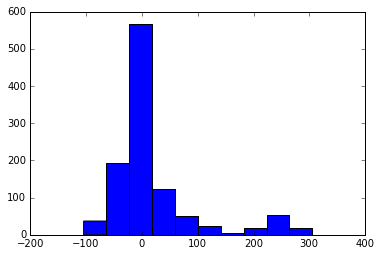

In [38]:
diff = [(actual-truth) for actual, truth in zip(y_pred, y_year_test)]
plt.hist(diff)

In [42]:
print max(y_year_train), min(y_year_train)
print max(y_year_test), min(y_year_test)

2012 1578
2012 1590
